# Lab 5: Spam Detection (with More Sample Code)

**Deadline**:

SAMPLE CODE

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**:

SAMPLE CODE

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1QeKHkMLRGez_Y5hvDny33Ey8puwX6sYn/view?usp=sharing

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import csv
import time
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tensorflow as tf

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [118]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

# location on Google Drive
master_path = r'/content/gdrive/My Drive/APS360_Personal_folder/Labs/Lab5_dataset/SMSSpamCollection'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
for line in open(master_path):
    print(line)
    break

with open(master_path, 'r') as file:
    file_content = file.readlines()

print(file_content[2])
print(len(file_content))

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

5574


Label values: "spam" and "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [120]:
spam_count, ham_count = 0, 0

for message in file_content:
    spam_count += int('spam' in message[:4])
    ham_count += int('ham' in message[:4])
print('spam_count=', spam_count)
print('ham_count=', ham_count)

spam_count= 747
ham_count= 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. Discrete space you're working with is much smaller. There are less characters than words in English, so it has less computational cost.
2. Character level RNN is good at forming sentences as it creates punctuation. 

Disadvantages: 
1. It’s not as good as the word-level RNN at capturing long-distance dependencies
2. It requires longer training time since the input is character instead of words.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [135]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1


fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(master_path, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)



train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

In [122]:
print("# of training data:", len(train))
print("# of validation data:", len(valid))
print("# of testing data:", len(test))

# of training data: 3343
# of validation data: 1115
# of testing data: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [136]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Explain why having a balanced training set is helpful for training our neural network:


*   It is important that we have equal amount of data samples from each class, because we want our model learn each class equally instead of favoring one of the class. If there is an inbalance in our dataset, our model will be difficult to predict result from the class that has less data samples. 



### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [137]:
text_field.build_vocab(train)
#text_field.vocab.stoi
print("text_field.vocab.stoi", text_field.vocab.stoi)
#text_field.vocab.itos
print("text_field.vocab.itos", text_field.vocab.itos)

text_field.vocab.stoi defaultdict(<function _default_unk_index at 0x7f6105787158>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '7': 37, '4': 38, 'N': 39, 'x': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'U': 49, 'M': 50, 'W': 51, 'H': 52, 'L': 53, 'D': 54, 'F': 55, 'B': 56, 'G': 57, 'Y': 58, '/': 59, '?': 60, "'": 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'X': 67, 'V': 68, '*': 69, 'K': 70, 'j': 71, 'J': 72, ')': 73, ';': 74, '+': 75, '"': 76, 'q': 77, '(': 78, 'Q': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'ü': 84, 'Z': 85, '$': 86, 'Ü': 87, '<': 88, '\x92': 89, '%': 90, '_': 91, '‘': 92, '|': 93, '\x93': 94, '“': 95, '[': 96, ']': 97, '’': 98, '…': 99, '–': 100, 'ú

1.   text_field.vocab.stoi: A collections.defaultdict instance mapping token strings to numerical identifiers.

2.   text_field.vocab.itos: A list of token strings indexed by their numerical identifiers.




### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [125]:
"""<unk>: out-of-dictionary characters
<pad>: padding """

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [138]:
def data_loader(data, batch_size=32):
    output_data = torchtext.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    return output_data

In [139]:
train_iter = data_loader(train)
valid_iter = data_loader(valid)

In [140]:
count = 0
paddings = []
max_lengths = []

for batch in train_iter:
    # get all sms lengths from the second tensor in batch.sms
    sms_lengths = batch.sms[1].detach().numpy()
    # get max length and append it
    max_length = np.amax(sms_lengths)
    max_lengths.append(max_length)
    # calculate total padding for each batch and append it
    total_padding = 0
    for length in sms_lengths:
        total_padding += max_length - length
    paddings.append(total_padding)    

    count += 1
    if count == 10:
        break

print("Paddings in rach batch:", paddings)
print("Maximum length of the input sequence in each batch:", max_lengths)

Paddings in rach batch: [11, 40, 9, 22, 0, 0, 42, 24, 0, 30]
Maximum length of the input sequence in each batch: [30, 106, 33, 74, 156, 135, 60, 29, 156, 148]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [129]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [170]:
# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes, hidden_units=50, num_layers=1):
    super(SpamRNN, self).__init__()
    self.name = "SpamRNN"
    self.num_layers = num_layers
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.hidden_units = hidden_units
    self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size * 2, hidden_units)
    self.fc2 = nn.Linear(hidden_units, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # concatenate the max-pooling and average-pooling of the RNN outputs
    x = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    # Pass the output of the last time step to the classifier
    x = self.fc1(x)
    x = self.fc2(F.relu(x)).squeeze(1)
    
    return x

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [182]:
def get_accuracy_loss(model, data_iter, criterion=nn.CrossEntropyLoss()):

    total_loss, total_acc, total_labels_length, count, correct = 0, 0, 0, 0, 0

    for batch in data_iter:
        # get messages and labels from batch
        msg = batch.sms[0]
        labels = batch.label  

        # get output from RNN
        output = model(msg)
        # calculate loss
        loss = criterion(output, labels)
        total_loss += loss.item()
        # calculate acc
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        count += 1
        total_labels_length += len(labels)

    total_loss = float(total_loss) / count
    total_acc = float(correct) / total_labels_length

    return total_acc, total_loss


In [177]:
def plotting(iterations, t_loss, v_loss, t_acc, v_acc):
    plt.title("Training/Validation Loss Curves")
    plt.plot(iterations, t_loss, label="Training")
    plt.plot(iterations, v_loss, label="Validation")
    plt.xlabel("# of iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training/Validation Accuracy Curves")
    plt.plot(iterations, t_acc, label="Training")
    plt.plot(iterations, v_acc, label="Validation")
    plt.xlabel("# of iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learn_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learn_rate,
                                                   epoch)
    return path

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [189]:
def train_function(model, train_data, valid_data, batch_size=32, num_epochs=30, learning_rate=0.001):
    torch.manual_seed(125)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)

    # Set up some numpy arrays to store the training/validation loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    intrations = np.zeros(num_epochs)

    start_time = time.time()
    print ("Training Started...")
    for epoch in range(num_epochs):
        for batch in train_data:
            # get message and label from batch
            msg = batch.sms[0]
            label = batch.label

            # get output from model
            out = model(msg)
            # calculate loss
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # get accuracy and loss for this epoch on training data
        train_acc[epoch], train_loss[epoch] = get_accuracy_loss(model, train_data)
        # get accuracy and loss for this epoch on validation data
        val_acc[epoch], val_loss[epoch] = get_accuracy_loss(model, valid_data)
        # get number of iterations
        intrations[epoch] = (epoch)
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        # displaying the epochs performance
        print(("Epoch {}: Train acc: {}, Train loss: {} | Validation acc: {}, Validation loss: {}").format(
            epoch + 1,
            round(train_acc[epoch]*100, 3),
            round(train_loss[epoch], 5),
            round(val_acc[epoch]*100, 3),
            round(val_loss[epoch], 5)))
        
    # show final training resilt summary
    print("===============Final training result summary===============")
    print("Training accuracy: ", round(train_acc[-1]*100, 3))
    print("Training loss: ", round(train_loss[-1], 5))
    print("Validation accuracy: ", round(val_acc[-1]*100, 3))
    print("Validation loss: ", round(val_loss[-1], 5))

    # print out the training time 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plot the curves 
    plotting(intrations, train_loss, val_loss, train_acc, val_acc)

Training Started...
Epoch 1: Train acc: 93.399, Train loss: 0.6219 | Validation acc: 96.233, Validation loss: 0.64847
Epoch 2: Train acc: 94.424, Train loss: 0.15188 | Validation acc: 98.117, Validation loss: 0.10069
Epoch 3: Train acc: 95.789, Train loss: 0.12492 | Validation acc: 98.296, Validation loss: 0.07678
Epoch 4: Train acc: 96.114, Train loss: 0.13117 | Validation acc: 96.054, Validation loss: 0.14577
Epoch 5: Train acc: 96.992, Train loss: 0.08396 | Validation acc: 97.309, Validation loss: 0.09572
Epoch 6: Train acc: 97.919, Train loss: 0.05594 | Validation acc: 98.206, Validation loss: 0.05752
Epoch 7: Train acc: 98.586, Train loss: 0.04126 | Validation acc: 98.027, Validation loss: 0.05501
Epoch 8: Train acc: 98.911, Train loss: 0.03532 | Validation acc: 98.924, Validation loss: 0.03721
Epoch 9: Train acc: 98.732, Train loss: 0.02973 | Validation acc: 98.834, Validation loss: 0.03871
Epoch 10: Train acc: 99.301, Train loss: 0.02217 | Validation acc: 98.206, Validation loss

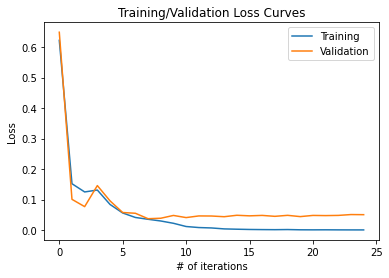

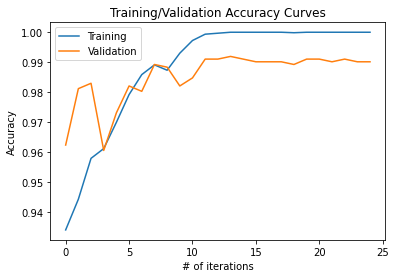

In [188]:
# get input size
input_size = len(text_field.vocab.itos)

# hyperparameters:
bs = 32
epochs = 25
lr = 0.07455
hidden_size = 128
hidden_units = 45

# get data iteration for each dataset
train_iter = data_loader(train, bs)
valid_iter = data_loader(valid, bs)

# get RNN model
model = SpamRNN(input_size=input_size, hidden_size=hidden_size, num_classes=2, hidden_units=hidden_units)
# train RNN model
train_function(model, train_iter, valid_iter, batch_size=bs, num_epochs=epochs, learning_rate=lr)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
"""
Hyperparameters that are chosen:
1. Number of hidden units between first fully-connected layer(fc1) and second fully-connected layer(fc2): hidden_units
2. Number of epoch: epochs
3. Learning rate: lr

Reasons of choosing above 3 hyperparameters:
1. Since we have a classifier (MLP) to classify whether the message is "ham" or "spam", we need to be
able to tune our classifier. Number of hidden units in the classify are chosen because it helps to tune 
the classifier.  

2. Epoch is a measure of the number of times all training data are used once to update the parameters. 
Increasing number of epoches can help us to observe the behaviour of the training and validation curves. 

3. The learning rate determines the size of the “step” that an optimizer takes during each iteration. 
Truning learning rate can help use to find a optimal global minima.

Tuning strategy:
I first tuned the number of epochs to 25 so that I'm able to see a complete behaviours of training and 
validation curves. Then, I found that the classifier can achieve a optimal accuracy when the number of 
hidden units in the classifer is set to 45. Finally, I started to tune the model with learning rate is 
set to 0.001. I tuned the learning rate by trying differnt value and finally found 0.07455 can achieve 
the optimal training and validation accuracy. 

Final setting of hyperparameters that are chosen:
1. hidden_units = 45
2. epochs = 25
3. lr = 0.07455
"""

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [191]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label != 1],
    valid.fields)

In [193]:
# get input size
input_size = len(text_field.vocab.itos)

# hyperparameters:
bs = 32
epochs = 25
lr = 0.07455
hidden_size = 128
hidden_units = 45

# get RNN model
model = SpamRNN(input_size=input_size, hidden_size=hidden_size, num_classes=2, hidden_units=hidden_units)

# get data iteration for each dataset
valid_spam_iter = data_loader(valid_spam, bs)
valid_nospam_iter = data_loader(valid_nospam, bs)

# load the best model 
path = get_model_name(model.name, batch_size=bs, learn_rate=lr, epoch=epochs-1)
state = torch.load(path)
model.load_state_dict(state)

# get false positive rate and false negative rate
spam_acc, _ = get_accuracy_loss(model, valid_spam_iter)
nospam_acc, _ = get_accuracy_loss(model, valid_nospam_iter)

print("false positive rate:", round((1 - spam_acc)*100, 3), "%")
print("false negative rate:", round((1 - nospam_acc)*100, 3), "%")

false positive rate: 7.746 %
false negative rate: 0.206 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

Impact of a false positive:
*   The user cannot receive a nonspam message (ham message) since the model fails to let nonspam message to pass. 

Impact of a false negative:
*   The user can receive a spam message since the model is failed to block it. 




## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [198]:
# get input size
input_size = len(text_field.vocab.itos)

# hyperparameters:
bs = 32
epochs = 25
lr = 0.07455
hidden_size = 128
hidden_units = 45

# get RNN model
model = SpamRNN(input_size=input_size, hidden_size=hidden_size, num_classes=2, hidden_units=hidden_units)

# get test data
test_iter = data_loader(test, bs)

test_acc, _ = get_accuracy_loss(model, test_iter)

print("Test accuracy:", round(test_acc*100, 2), "%") 

Test accuracy: 87.7 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [201]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label != 1],
    test.fields)

# get data iteration for each dataset
test_spam_iter = data_loader(test_spam, 32)
test_nospam_iter = data_loader(test_nospam, 32)

In [202]:
# load the best model 
path = get_model_name(model.name, batch_size=bs, learn_rate=lr, epoch=epochs-1)
state = torch.load(path)
model.load_state_dict(state)

# get false positive rate and false negative rate
spam_acc, _ = get_accuracy_loss(model, test_spam_iter)
nospam_acc, _ = get_accuracy_loss(model, test_nospam_iter)

print("false positive rate:", round((1 - spam_acc)*100, 3), "%")
print("false negative rate:", round((1 - nospam_acc)*100, 3), "%")

false positive rate: 8.759 %
false negative rate: 0.307 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [210]:
msg = "machine learning is sooo cool!"
dictionary = text_field.vocab.stoi
msg_index = []

# look up the index of each character
for char in msg:
    index = int(dictionary[char])
    msg_index.append(index)

# get the message to dataloader
msg_index = np.array([msg_index])
msg_loader = DataLoader(msg_index, shuffle=True)

# get output 
for batch in iter(msg_loader):
    output = F.softmax(model(batch.long()), dim=1)

output = output[0][0].detach().numpy()
print("The probability of the given message is not spam:", round(output*100, 2), "%")

The probability of the given message is not spam: 100.0 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
"""
1. Do you think detecting spam is an easy or difficult task?
Yes, the model that we built can only cover the similar spam messages that learnt from the training data.
There are always new type of spam messages, and it is very difficult to cover all of them. In additional, 
the model is very difficult to reduce the false positive rate and false negative rate down to zero, and they
are different from message to message. So the model may block some important messages or let some spam 
messages to pass the filter. 

2. A simple baseline model.
The simple baseline model can be an algorithm to detect the most frequent words that are used in spam messages.
Then, the messages that contain these key words will be treated as spam messages. 
"""